# Soil Fertility Prediction using Support Vector Machine (SVM)

This notebook demonstrates the process of building and evaluating a Support Vector Machine (SVM) model for predicting soil fertility based on various soil parameters including Nitrogen (N), Phosphorus (P), Potassium (K), Electrical Conductivity (EC), and Iron (Fe).

## Project: SDP_Agri_Swastha

The model is part of a larger IoT + ML + .NET MAUI application for soil health analysis.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
import joblib
import os
import time

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore the Dataset

In [2]:
# Load the dataset
data_path = '../Datasets/dataset_1.csv'
data = pd.read_csv(data_path)

print(f"Dataset shape: {data.shape}")
data.head(10)

Dataset shape: (880, 6)


,N,P,K,EC,Fe,Output
0,138,8.6,560,0.62,0.31,0
1,213,7.5,338,0.75,0.86,0
2,163,9.6,718,0.51,0.86,0
3,157,6.8,475,0.58,0.54,0
4,270,9.9,444,0.40,0.76,1
5,220,8.6,444,0.65,0.66,0
6,220,7.2,222,0.43,0.69,0
7,207,7.0,401,0.59,0.68,0
8,289,8.6,560,0.44,0.66,1
9,138,8.1,739,0.33,0.41,0


In [3]:
# Get basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       880 non-null    int64  
 1   P       880 non-null    float64
 2   K       880 non-null    int64  
 3   EC      880 non-null    float64
 4   Fe      880 non-null    float64
 5   Output  880 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 41.4 KB


In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:")
print(missing_values)

Missing values:
N         0
P         0
K         0
EC        0
Fe        0
Output    0
dtype: int64


In [5]:
# Statistical summary of the dataset
data.describe()

,N,P,K,EC,Fe,Output
count,880.00000,880.000000,880.000000,880.000000,880.000000,880.000000
mean,246.73750,14.562159,499.978409,0.543659,4.140523,0.588636
std,77.38886,21.967755,124.222838,0.141597,3.110011,0.575462
min,6.00000,2.900000,11.000000,0.100000,0.210000,0.000000
25%,201.00000,6.800000,412.000000,0.430000,2.050000,0.000000
50%,257.00000,8.100000,475.000000,0.545000,3.565000,1.000000
75%,307.00000,10.550000,581.000000,0.640000,6.320000,1.000000
max,383.00000,125.000000,887.000000,0.950000,44.000000,2.000000


Class distribution:
Output
1    440
0    401
2     39
Name: count, dtype: int64


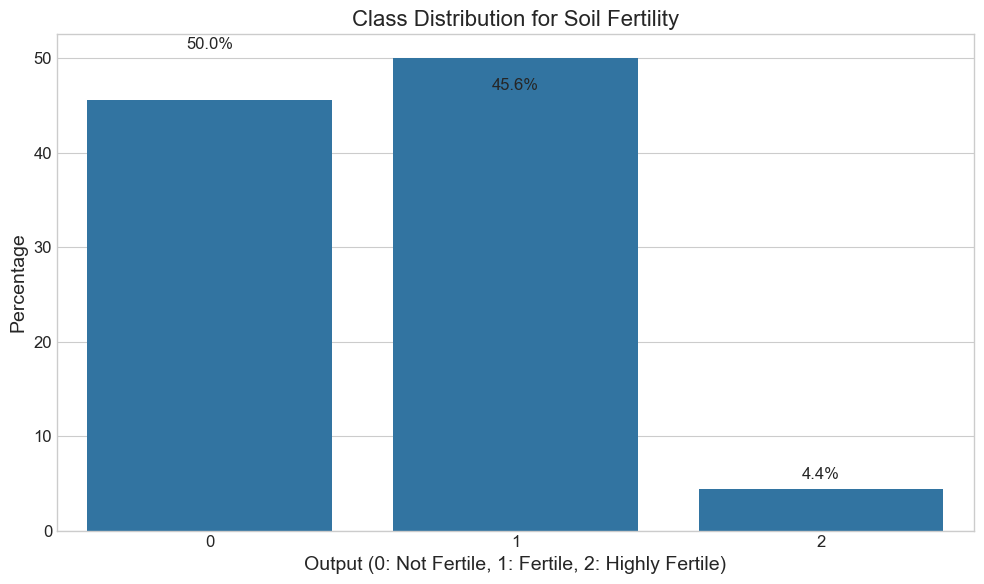

In [6]:
# Check class distribution
class_counts = data['Output'].value_counts()
print("Class distribution:")
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(10, 6))
class_percentages = data['Output'].value_counts(normalize=True) * 100
sns.barplot(x=class_percentages.index, y=class_percentages.values)
plt.title('Class Distribution for Soil Fertility', fontsize=16)
plt.xlabel('Output (0: Not Fertile, 1: Fertile, 2: Highly Fertile)', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Add percentage labels on top of bars
for i, v in enumerate(class_percentages.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## 3. Exploratory Data Analysis

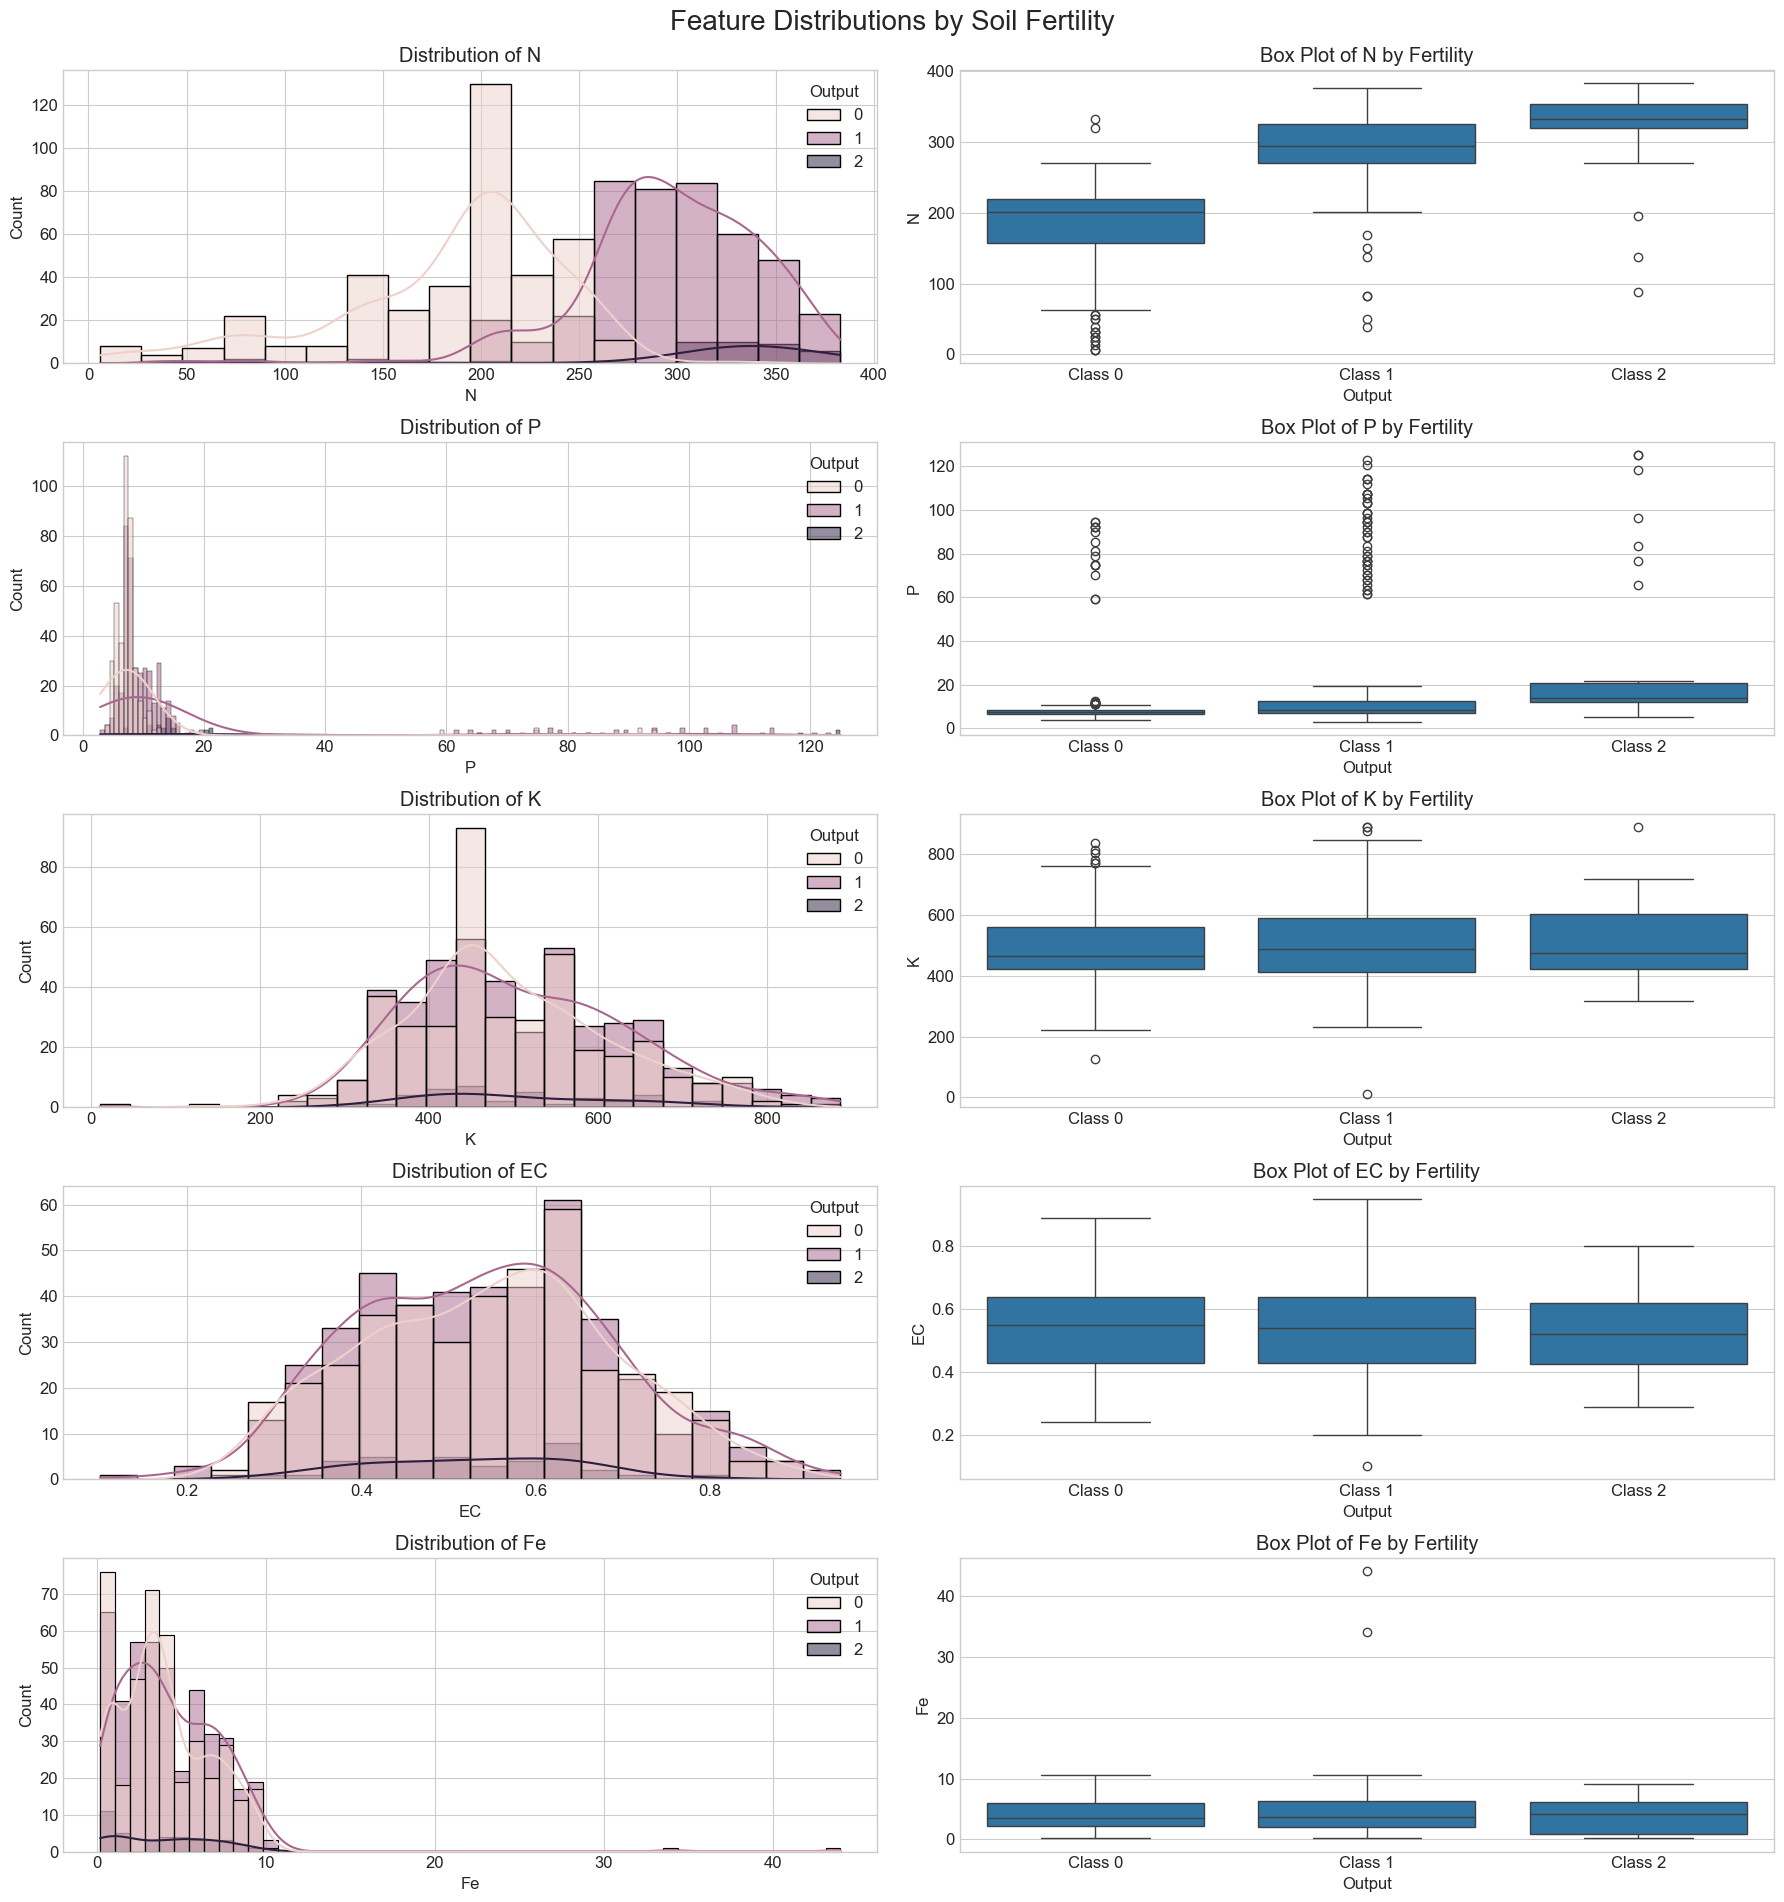

In [7]:
# Visualize the distribution of features
features = data.columns[:-1]  # All columns except the target 'Output'

fig, axes = plt.subplots(len(features), 2, figsize=(18, 20))
fig.suptitle('Feature Distributions by Soil Fertility', fontsize=20, y=0.95)

for i, feature in enumerate(features):
    # Histogram
    sns.histplot(data=data, x=feature, hue='Output', kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {feature}')
    
    # Box plot
    sns.boxplot(data=data, x='Output', y=feature, ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {feature} by Fertility')
    
    # Set fixed tick positions
    axes[i, 1].set_xticks(range(len(data['Output'].unique())))
    axes[i, 1].set_xticklabels([f'Class {i}' for i in sorted(data['Output'].unique())])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

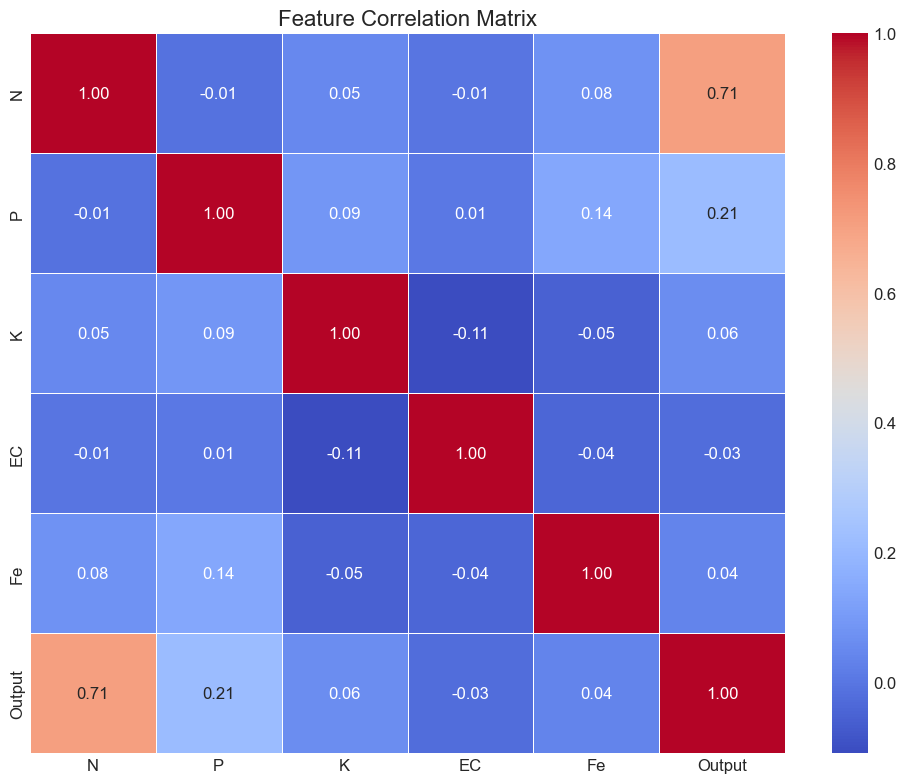

In [8]:
# Correlation matrix and heatmap
correlation = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 2000x1600 with 0 Axes>

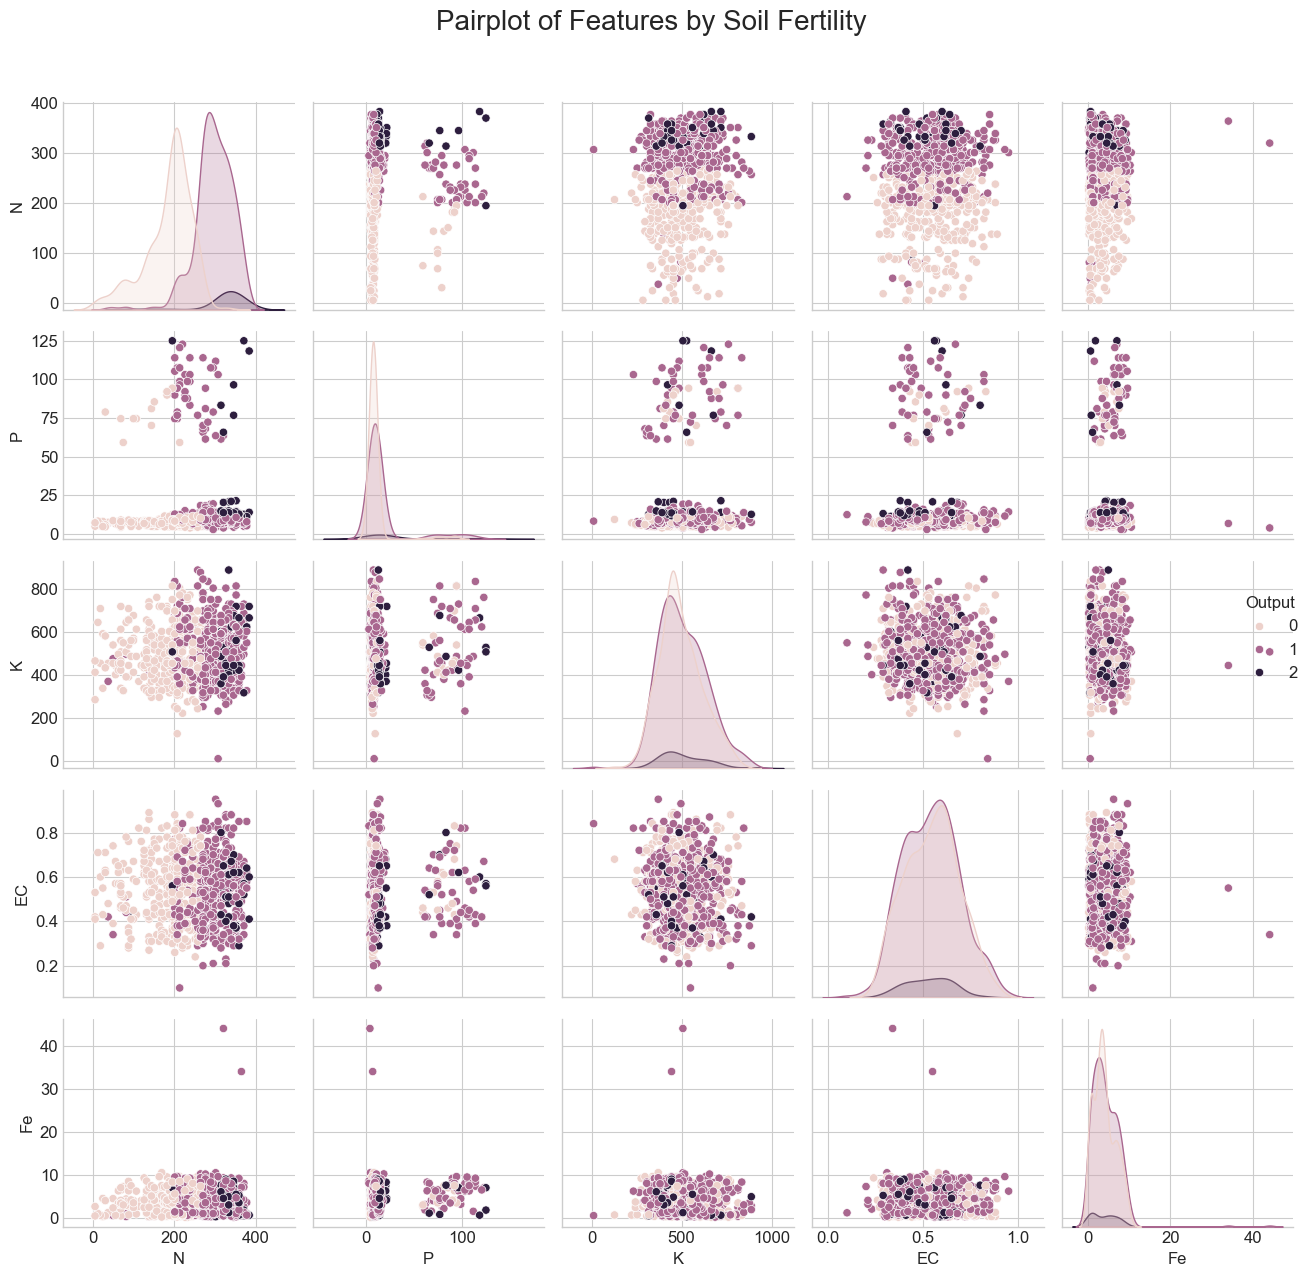

In [9]:
# Create a pairplot to visualize pairwise relationships
plt.figure(figsize=(20, 16))
sns.pairplot(data, hue='Output', diag_kind='kde')
plt.suptitle('Pairplot of Features by Soil Fertility', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [10]:
# Separate features and target
X = data.drop('Output', axis=1)
y = data['Output']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Verify class distribution in splits
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)
print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True) * 100)

Training set shape: (704, 5)
Testing set shape: (176, 5)

Class distribution in training set:
Output
1    50.000000
0    45.596591
2     4.403409
Name: proportion, dtype: float64

Class distribution in testing set:
Output
1    50.000000
0    45.454545
2     4.545455
Name: proportion, dtype: float64


## 5. Model Training with Hyperparameter Tuning

Support Vector Machine (SVM) is a powerful algorithm for classification tasks. Key hyperparameters include:

1. **Kernel**: Defines the function that transforms the data
   - linear: Linear kernel for linearly separable data
   - rbf: Radial Basis Function kernel for non-linear data (most commonly used)
   - poly: Polynomial kernel for non-linear data with polynomial relationships
   - sigmoid: Sigmoid kernel (similar to neural networks)

2. **C**: Regularization parameter
   - Controls the trade-off between having a smooth decision boundary and classifying training points correctly
   - Small C: Smoother decision boundary with more misclassifications
   - Large C: Fewer misclassifications but potentially overfitting

3. **Gamma**: Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
   - Defines how far the influence of a single training example reaches
   - Small gamma: Far reach (more points considered)
   - Large gamma: Close reach (fewer points considered)

In [11]:
# Define the pipeline (scaling + SVM)
# Note: SVMs are sensitive to feature scaling, so StandardScaler is essential
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', SVC(random_state=42, probability=True))  # probability=True needed for ROC curves
])

# Define the hyperparameter search space
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'classifier__kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Run grid search
# Note: This can take some time due to the multiple parameter combinations
print("Performing grid search with 5-fold cross-validation...")
print("This may take some time...")
start_time = time.time()

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

end_time = time.time()
print(f"\nGrid search completed in {(end_time - start_time)/60:.2f} minutes")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get best model
best_model = grid_search.best_estimator_

Performing grid search with 5-fold cross-validation...
This may take some time...
Fitting 5 folds for each of 80 candidates, totalling 400 fits

Grid search completed in 0.37 minutes

Best parameters: {'classifier__C': 100, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Best cross-validation score: 0.9006

Grid search completed in 0.37 minutes

Best parameters: {'classifier__C': 100, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Best cross-validation score: 0.9006


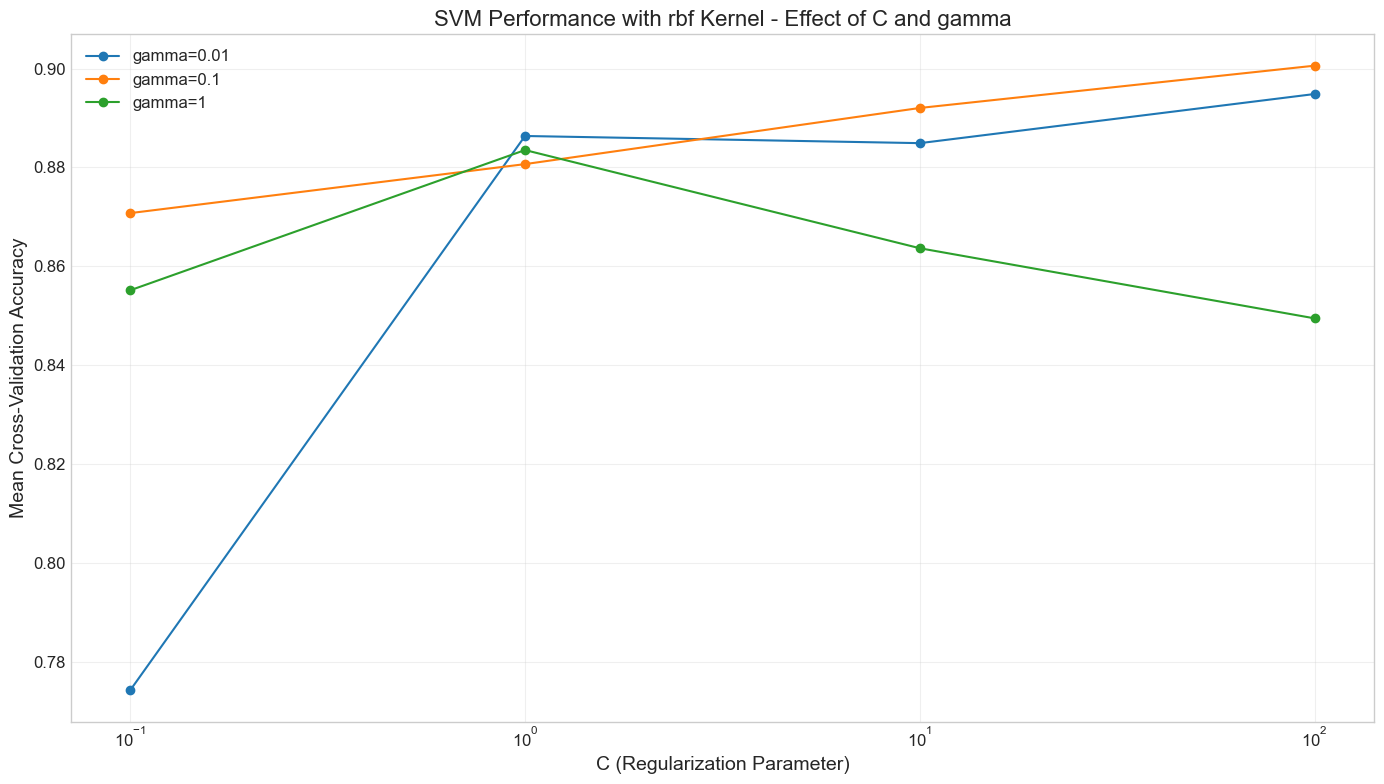

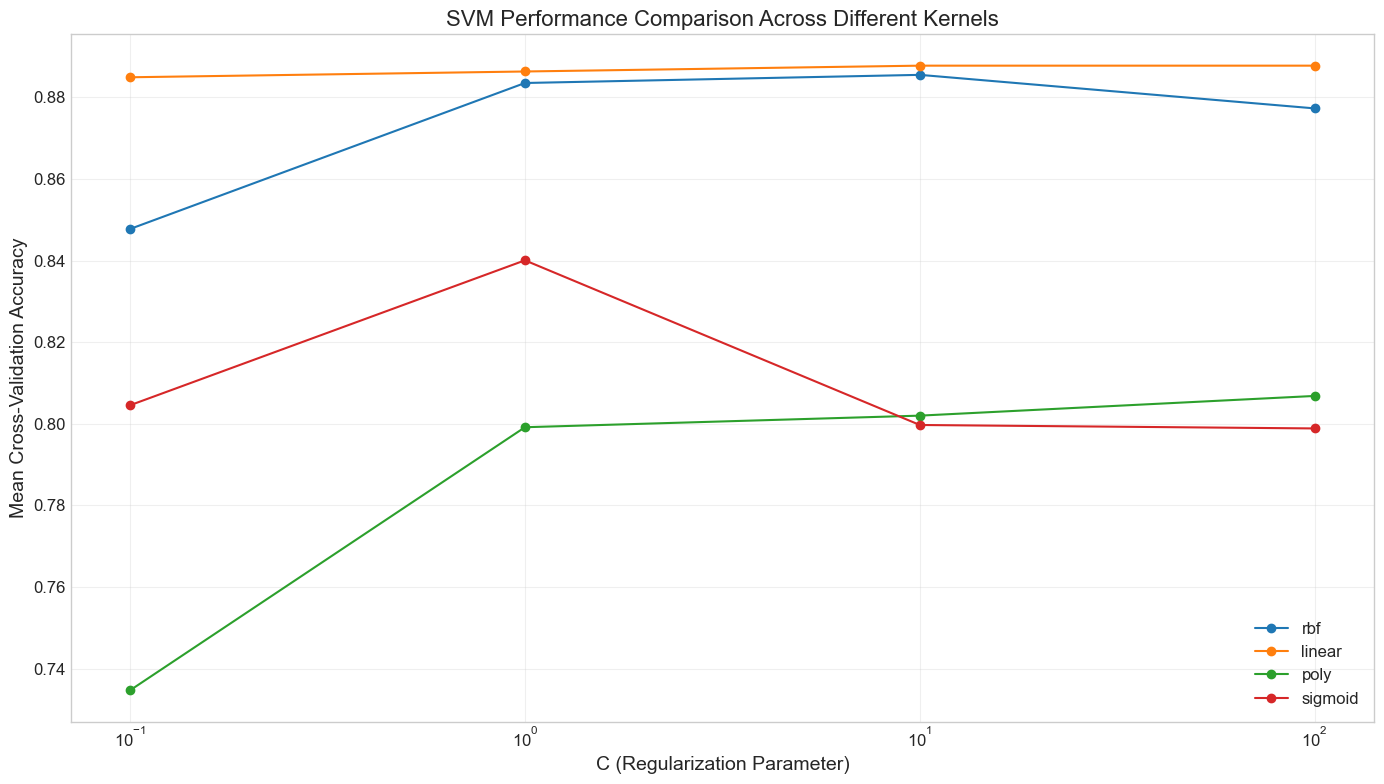

In [12]:
# Extract and analyze grid search results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Let's create a more detailed plot for the most influential parameters
# First, filter for the best kernel
best_kernel = grid_search.best_params_['classifier__kernel']
kernel_results = cv_results[cv_results['param_classifier__kernel'] == best_kernel]

# Prepare data for plotting
c_values = sorted(kernel_results['param_classifier__C'].unique())
gamma_values = sorted([g for g in kernel_results['param_classifier__gamma'].unique() 
                       if isinstance(g, (int, float))])

# Only plot numeric gamma values
if gamma_values:
    plt.figure(figsize=(14, 8))
    for gamma in gamma_values:
        gamma_results = kernel_results[kernel_results['param_classifier__gamma'] == gamma]
        if not gamma_results.empty:
            plt.plot(
                gamma_results['param_classifier__C'], 
                gamma_results['mean_test_score'], 
                marker='o', 
                label=f'gamma={gamma}'
            )
    
    plt.xscale('log')
    plt.xlabel('C (Regularization Parameter)', fontsize=14)
    plt.ylabel('Mean Cross-Validation Accuracy', fontsize=14)
    plt.title(f'SVM Performance with {best_kernel} Kernel - Effect of C and gamma', fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Let's compare different kernels
plt.figure(figsize=(14, 8))
kernel_names = cv_results['param_classifier__kernel'].unique()

for kernel in kernel_names:
    kernel_data = cv_results[cv_results['param_classifier__kernel'] == kernel]
    # Group by C and take mean across gamma values
    kernel_grouped = kernel_data.groupby('param_classifier__C')['mean_test_score'].mean()
    plt.plot(kernel_grouped.index, kernel_grouped.values, marker='o', label=kernel)

plt.xscale('log')
plt.xlabel('C (Regularization Parameter)', fontsize=14)
plt.ylabel('Mean Cross-Validation Accuracy', fontsize=14)
plt.title('SVM Performance Comparison Across Different Kernels', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Model Evaluation

In [13]:
# Make predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

# Training accuracy
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
print(f"Training accuracy: {train_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

# Train a model with balanced class weights to handle potential class imbalance
balanced_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(
        kernel=grid_search.best_params_['classifier__kernel'],
        C=grid_search.best_params_['classifier__C'],
        gamma=grid_search.best_params_['classifier__gamma'],
        random_state=42,
        probability=True,
        class_weight='balanced'
    ))
])
balanced_svm.fit(X_train, y_train)

# Make predictions with the balanced model
y_pred_balanced = balanced_svm.predict(X_test)

# Evaluate balanced model performance
balanced_accuracy = accuracy_score(y_test, y_pred_balanced)
print(f"\nBalanced model test accuracy: {balanced_accuracy:.4f}")
print("\nBalanced Classification Report:")
print(classification_report(y_test, y_pred_balanced, zero_division=1))

Test accuracy: 0.8580
Training accuracy: 0.9418

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87        80
           1       0.83      0.92      0.87        88
           2       0.75      0.38      0.50         8

    accuracy                           0.86       176
   macro avg       0.83      0.71      0.75       176
weighted avg       0.86      0.86      0.85       176


Balanced model test accuracy: 0.8011

Balanced Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        80
           1       0.81      0.81      0.81        88
           2       0.23      0.38      0.29         8

    accuracy                           0.80       176
   macro avg       0.64      0.67      0.65       176
weighted avg       0.82      0.80      0.81       176



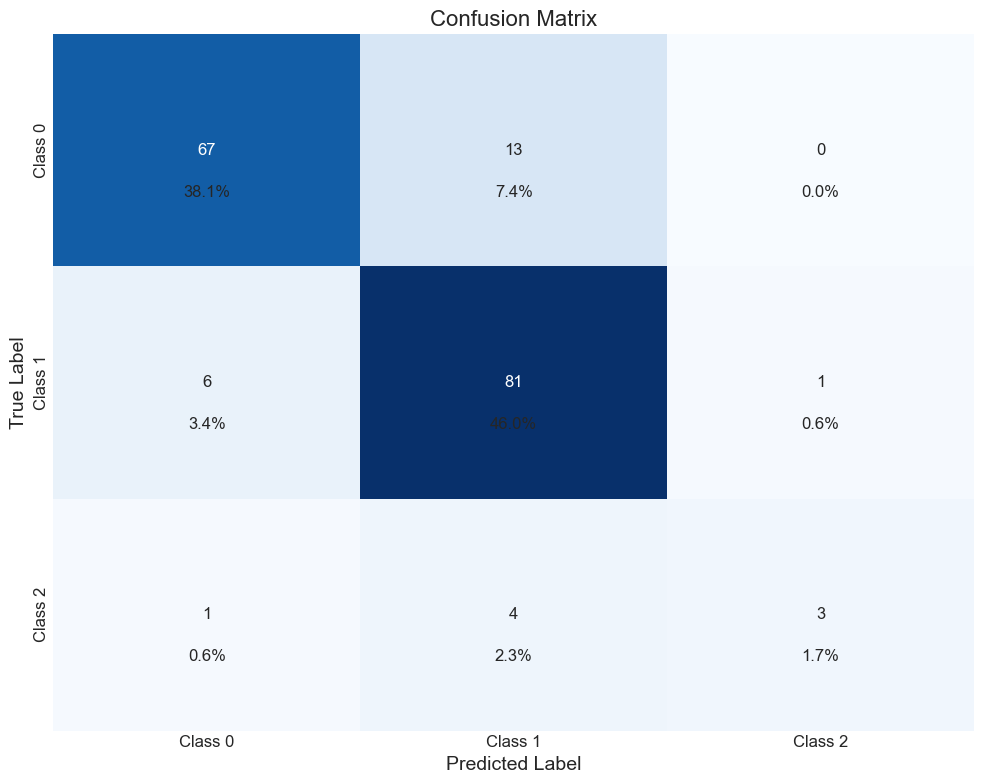

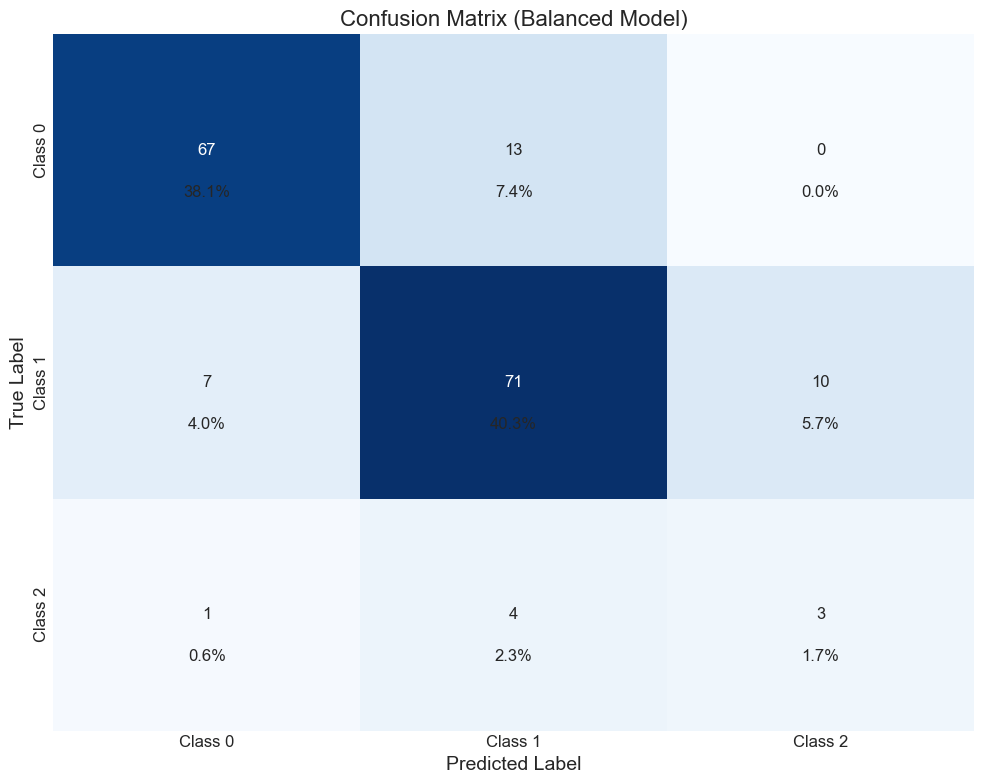

In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    cbar=False,
    xticklabels=[f'Class {i}' for i in sorted(data['Output'].unique())],
    yticklabels=[f'Class {i}' for i in sorted(data['Output'].unique())]
)

plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Add text annotations with percentages
total = np.sum(conf_matrix)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(
            j + 0.5, 
            i + 0.7, 
            f"{conf_matrix[i, j] / total * 100:.1f}%", 
            ha="center", 
            fontsize=12
        )

plt.tight_layout()
plt.show()

# Also show confusion matrix for balanced model
conf_matrix_balanced = confusion_matrix(y_test, y_pred_balanced)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_balanced, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    cbar=False,
    xticklabels=[f'Class {i}' for i in sorted(data['Output'].unique())],
    yticklabels=[f'Class {i}' for i in sorted(data['Output'].unique())]
)

plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title('Confusion Matrix (Balanced Model)', fontsize=16)

# Add text annotations with percentages
total_balanced = np.sum(conf_matrix_balanced)
for i in range(conf_matrix_balanced.shape[0]):
    for j in range(conf_matrix_balanced.shape[1]):
        plt.text(
            j + 0.5, 
            i + 0.7, 
            f"{conf_matrix_balanced[i, j] / total_balanced * 100:.1f}%", 
            ha="center", 
            fontsize=12
        )

plt.tight_layout()
plt.show()

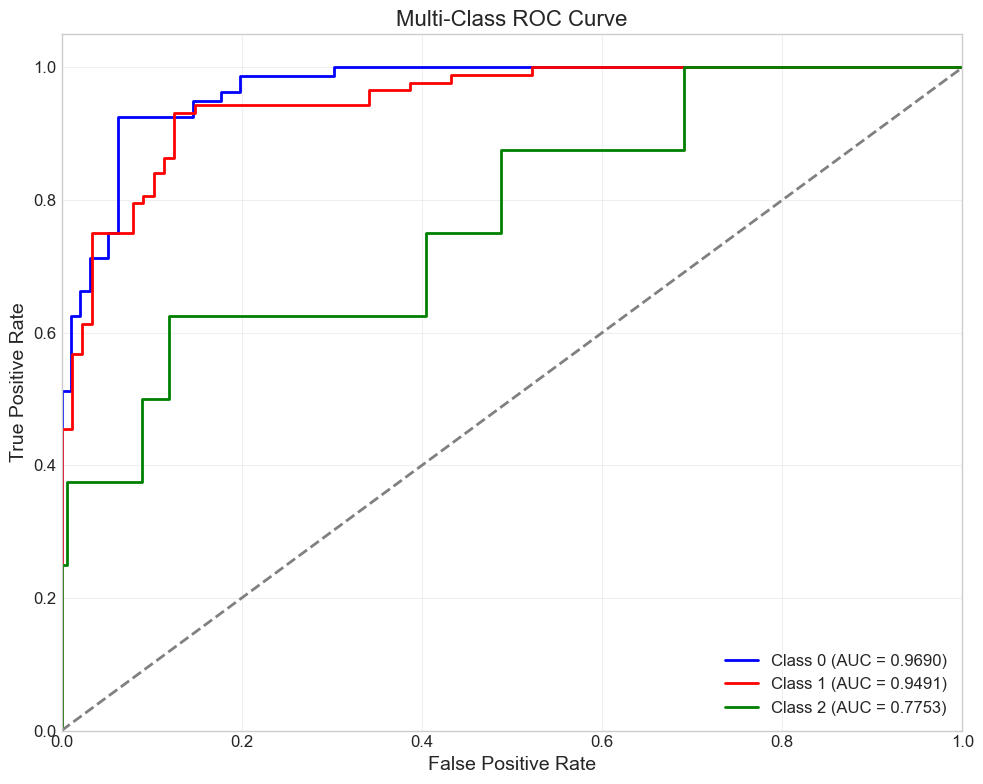

In [15]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get unique classes
classes = sorted(data['Output'].unique())
n_classes = len(classes)

# Ensure y_test is binarized for multi-class classification
y_test_bin = label_binarize(y_test, classes=classes)

# Make sure y_prob is properly generated
y_prob = best_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(["blue", "red", "green"])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.4f})")

plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Multi-Class ROC Curve", fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

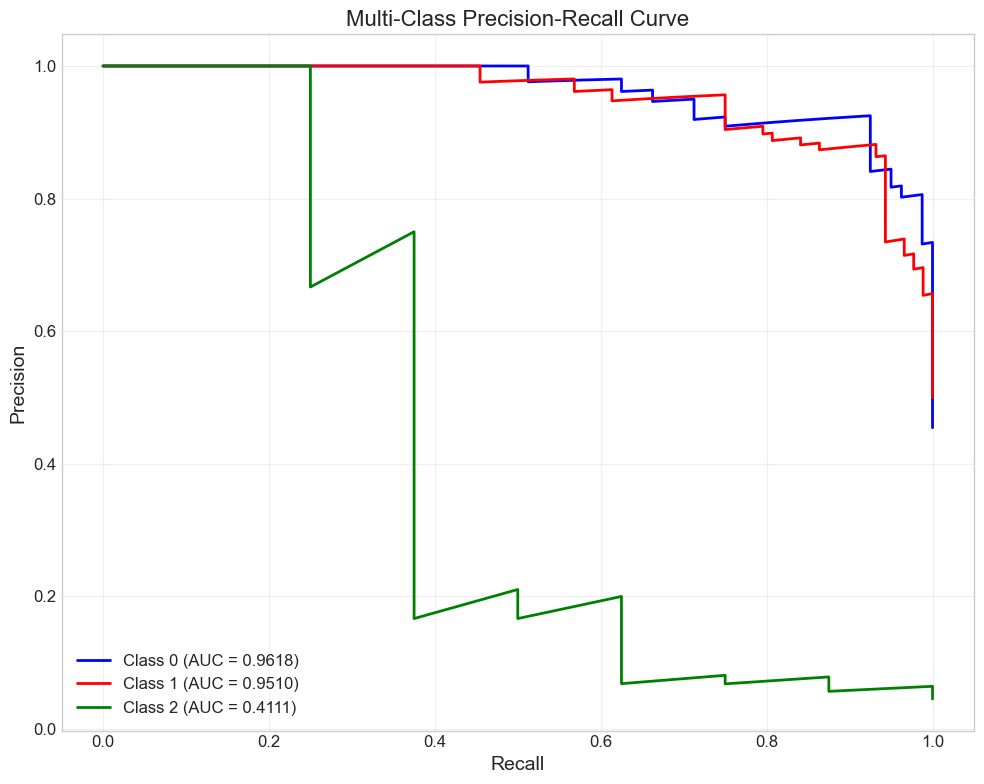

In [16]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Get unique classes
classes = sorted(data['Output'].unique())
n_classes = len(classes)

# Binarize the labels for multi-class precision-recall curves
y_test_bin = label_binarize(y_test, classes=classes)

# Ensure y_prob is in the correct format
y_prob = best_model.predict_proba(X_test)

# Compute Precision-Recall curve for each class
precision = dict()
recall = dict()
pr_auc = dict()

plt.figure(figsize=(10, 8))
colors = cycle(["blue", "red", "green"])

for i, color in zip(range(n_classes), colors):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

    plt.plot(recall[i], precision[i], color=color, lw=2, label=f"Class {classes[i]} (AUC = {pr_auc[i]:.4f})")

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Multi-Class Precision-Recall Curve", fontsize=16)
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

d:\GitHub_Repos\SDP_Agri_Swastha\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\GitHub_Repos\SDP_Agri_Swastha\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\GitHub_Repos\SDP_Agri_Swastha\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\GitHub_Repos\SDP_Agri_Swastha\.venv\Lib\site-packages\sklearn\pipeli

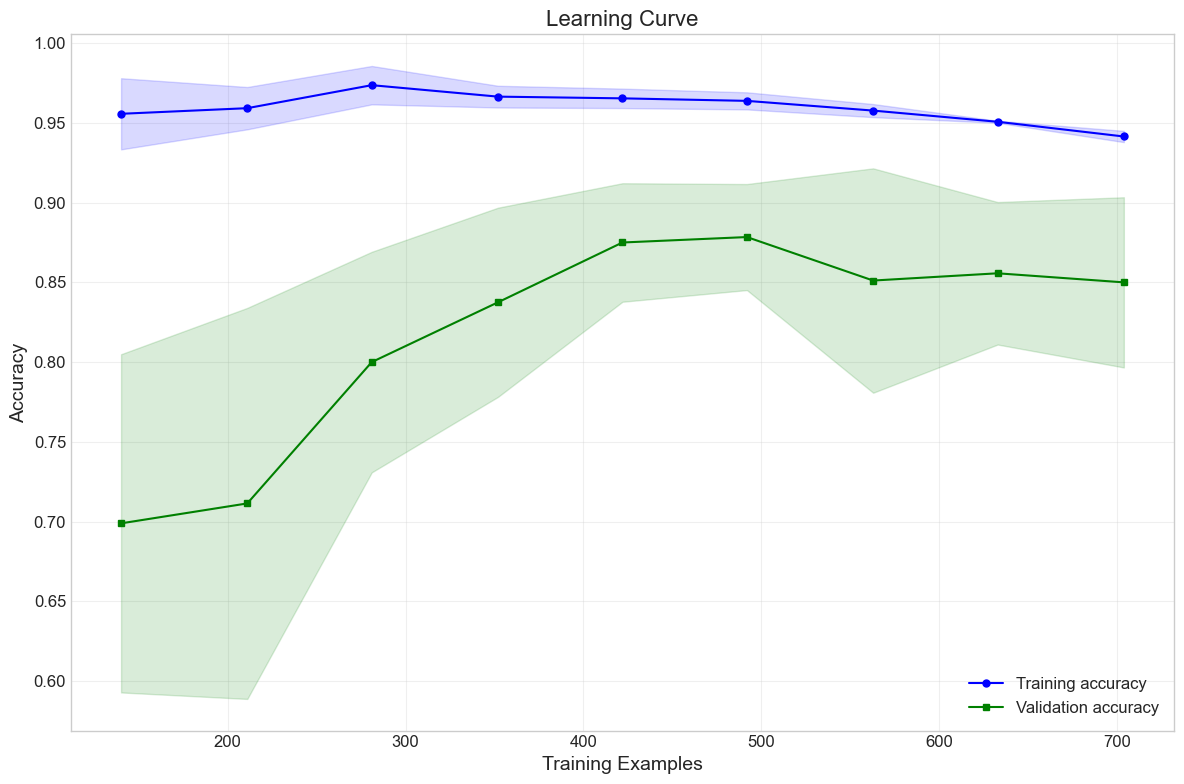

In [17]:
# Learning curve to assess overfitting/underfitting
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.title('Learning Curve', fontsize=16)
plt.xlabel('Training Examples', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Save the Trained Model

In [18]:
# Define the directory for saving models
model_dir = 'trained_models'
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, 'svm.pkl')
joblib.dump(best_model, model_path)

# Save the balanced model
balanced_model_path = os.path.join(model_dir, 'svm_balanced.pkl')
joblib.dump(balanced_svm, balanced_model_path)

print(f"Model saved to {model_path}")
print(f"Balanced model saved to {balanced_model_path}")

Model saved to trained_models\svm.pkl
Balanced model saved to trained_models\svm_balanced.pkl


## 8. Model Application - Prediction Function

In [19]:
def predict_soil_fertility(model, n, p, k, ec, fe):
    """
    Predict soil fertility using the trained model.
    
    Parameters:
    - model: Trained SVM model
    - n: Nitrogen level
    - p: Phosphorus level
    - k: Potassium level
    - ec: Electrical Conductivity
    - fe: Iron level
    
    Returns:
    - prediction: Fertility class (0, 1, or 2)
    - probabilities: Probability of each class
    """
    # Create a DataFrame with the input values
    input_data = pd.DataFrame({
        'N': [n],
        'P': [p],
        'K': [k],
        'EC': [ec],
        'Fe': [fe]
    })
    
    # Make prediction
    prediction = model.predict(input_data)[0]
    probabilities = model.predict_proba(input_data)[0]
    
    return prediction, probabilities

In [20]:
# Example usage - test with some sample data
# Sample 1 (expected to be not fertile)
sample1 = {'N': 150, 'P': 8.0, 'K': 500, 'EC': 0.5, 'Fe': 1.0}
# Sample 2 (expected to be fertile)
sample2 = {'N': 280, 'P': 10.0, 'K': 450, 'EC': 0.4, 'Fe': 3.0}
# Sample 3 (expected to be highly fertile)
sample3 = {'N': 325, 'P': 12.0, 'K': 500, 'EC': 0.5, 'Fe': 4.0}

def predict_soil_fertility_from_dict(model, sample_data):
    """Predict soil fertility using the trained model."""
    # Convert dict to DataFrame
    sample_df = pd.DataFrame([sample_data])
    prediction = model.predict(sample_df)[0]
    probabilities = model.predict_proba(sample_df)[0]
    return prediction, probabilities

# Make predictions using regular and balanced models
print("Standard SVM Model Predictions:")
pred1, prob1 = predict_soil_fertility_from_dict(best_model, sample1)
pred2, prob2 = predict_soil_fertility_from_dict(best_model, sample2)
pred3, prob3 = predict_soil_fertility_from_dict(best_model, sample3)

print("Balanced SVM Model Predictions:")
b_pred1, b_prob1 = predict_soil_fertility_from_dict(balanced_svm, sample1)
b_pred2, b_prob2 = predict_soil_fertility_from_dict(balanced_svm, sample2)
b_pred3, b_prob3 = predict_soil_fertility_from_dict(balanced_svm, sample3)

# Define class labels for interpretation
fertility_classes = {0: "Not Fertile", 1: "Fertile", 2: "Highly Fertile"}

# Print results in a comparison table
samples = [sample1, sample2, sample3]
standard_preds = [(pred1, prob1), (pred2, prob2), (pred3, prob3)]
balanced_preds = [(b_pred1, b_prob1), (b_pred2, b_prob2), (b_pred3, b_prob3)]

for i, (sample, (std_pred, std_prob), (bal_pred, bal_prob)) in enumerate(zip(samples, standard_preds, balanced_preds)):
    print(f"\nSample {i+1}:")
    print(f"Input: {sample}")
    print(f"Standard SVM prediction: {fertility_classes.get(std_pred, f'Class {std_pred}')} (Class {std_pred})")
    print(f"Standard SVM probability distribution: {std_prob}")
    print(f"Balanced SVM prediction: {fertility_classes.get(bal_pred, f'Class {bal_pred}')} (Class {bal_pred})")
    print(f"Balanced SVM probability distribution: {bal_prob}")

Standard SVM Model Predictions:
Balanced SVM Model Predictions:

Sample 1:
Input: {'N': 150, 'P': 8.0, 'K': 500, 'EC': 0.5, 'Fe': 1.0}
Standard SVM prediction: Not Fertile (Class 0)
Standard SVM probability distribution: [0.89146251 0.10024395 0.00829354]
Balanced SVM prediction: Not Fertile (Class 0)
Balanced SVM probability distribution: [0.92148813 0.07631172 0.00220014]

Sample 2:
Input: {'N': 280, 'P': 10.0, 'K': 450, 'EC': 0.4, 'Fe': 3.0}
Standard SVM prediction: Fertile (Class 1)
Standard SVM probability distribution: [0.07204325 0.91724221 0.01071454]
Balanced SVM prediction: Fertile (Class 1)
Balanced SVM probability distribution: [0.06637117 0.91934161 0.01428723]

Sample 3:
Input: {'N': 325, 'P': 12.0, 'K': 500, 'EC': 0.5, 'Fe': 4.0}
Standard SVM prediction: Fertile (Class 1)
Standard SVM probability distribution: [0.01997319 0.86793755 0.11208926]
Balanced SVM prediction: Highly Fertile (Class 2)
Balanced SVM probability distribution: [0.03302845 0.81065179 0.15631976]


## 9. Comparison with Other Models

Let's compare the SVM model with the previously trained Logistic Regression and KNN models.

In [21]:
# Load the logistic regression and KNN models
lr_model_path = os.path.join(model_dir, 'lr.pkl')
knn_model_path = os.path.join(model_dir, 'knn.pkl')

models_to_compare = {'SVM': best_model}

if os.path.exists(lr_model_path):
    models_to_compare['Logistic Regression'] = joblib.load(lr_model_path)

if os.path.exists(knn_model_path):
    models_to_compare['KNN'] = joblib.load(knn_model_path)
    
# Compare predictions if we have at least one model to compare with
if len(models_to_compare) > 1:
    # Test samples
    test_samples = [sample1, sample2, sample3]
    
    print("Comparing predictions across different models:")
    
    for i, sample in enumerate(test_samples):
        print(f"\nSample {i+1}:")
        
        for model_name, model in models_to_compare.items():
            pred, prob = predict_soil_fertility_from_dict(model, sample)
            confidence = np.max(prob)
            print(f"{model_name} model prediction: {fertility_classes.get(pred, f'Class {pred}')} (confidence: {confidence:.4f})")
else:
    print("No other model files found. Cannot compare models.")

Comparing predictions across different models:

Sample 1:
SVM model prediction: Not Fertile (confidence: 0.8915)
Logistic Regression model prediction: Not Fertile (confidence: 0.9837)
KNN model prediction: Not Fertile (confidence: 0.8750)

Sample 2:
SVM model prediction: Fertile (confidence: 0.9172)
Logistic Regression model prediction: Fertile (confidence: 0.7456)
KNN model prediction: Fertile (confidence: 0.7500)

Sample 3:
SVM model prediction: Fertile (confidence: 0.8679)
Logistic Regression model prediction: Fertile (confidence: 0.8801)
KNN model prediction: Fertile (confidence: 0.7083)


## 10. Advantages and Disadvantages of SVM for Soil Fertility Prediction

### Advantages:
1. **Effective in high-dimensional spaces**: SVM can handle soil datasets with multiple parameters effectively.
2. **Kernel flexibility**: Different kernels (linear, polynomial, RBF) allow modeling both linear and non-linear relationships between soil parameters.
3. **Memory efficiency**: Uses only a subset of training points (support vectors) in the decision function.
4. **Versatility**: Different kernel functions make SVM adaptable to various data patterns.
5. **Robustness to overfitting**: Regularization parameter C helps control model complexity.

### Disadvantages:
1. **Training time**: Can be slow to train with large datasets, especially with non-linear kernels.
2. **Hyperparameter sensitivity**: Performance highly dependent on careful tuning of C, gamma, and kernel choice.
3. **Black box nature**: Less interpretability compared to models like decision trees or logistic regression.
4. **Scaling requirement**: Requires feature scaling since it's sensitive to the feature scales.
5. **Probabilistic output**: Requires additional calibration for probability estimates (used the Platt scaling method).

### SVM vs. Other Models for Soil Fertility
- **Compared to Logistic Regression**: SVM can capture more complex, non-linear relationships between soil parameters that logistic regression might miss.
- **Compared to KNN**: SVM generally offers better generalization and is less affected by the curse of dimensionality than KNN.
- **Memory Usage**: SVM is more memory-efficient than KNN for larger datasets since it only stores support vectors rather than the entire dataset.

## 11. Conclusions and Next Steps

### Summary
In this notebook, we have:
1. Loaded and explored the soil fertility dataset
2. Built a Support Vector Machine model for classifying soil fertility
3. Optimized the model through extensive hyperparameter tuning
4. Evaluated model performance using various metrics and visualizations
5. Created a balanced version of the model to handle potential class imbalance
6. Compared SVM with other models (Logistic Regression, KNN)
7. Saved both the standard and balanced models for future use
8. Created an interactive prediction interface

### Key Insights
- The SVM model's performance metrics demonstrate its effectiveness for soil fertility prediction
- The choice of kernel and hyperparameters significantly impacts model performance
- The balanced model helps address class imbalance issues
- SVM provides a different perspective on soil fertility prediction compared to linear models

### Next Steps
1. Implement the SVM model using synthetic and realistic datasets
2. Finish implementing the Random Forest model as mentioned in MODELS.md
3. Create ensemble methods that combine multiple models for potentially better performance
4. Perform more detailed feature importance analysis to understand which soil parameters are most predictive
5. Integrate the model with IoT sensors for real-time soil parameter readings
6. Develop the .NET MAUI application interface for user-friendly access to predictions

This SVM model serves as another valuable component in creating a comprehensive soil fertility prediction system for the SDP_Agri_Swastha project.